In [1]:
include("foamLia/foamLia.jl")
using foamLia

baseCase = OpenFoam("/Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase");
initCase(baseCase,"foamLia/test/juliabase/");
faces,cells = readMesh(baseCase);
points,indices = reshapeMesh(baseCase);

# let's go get the foward four points of each cell
# only get the yz coordinates
cellPoints = zeros(size(baseCase.fullMesh["cellFaces"])[2],4,3)
for cellID in 1:size(baseCase.fullMesh["cellFaces"])[2]
    faces = baseCase.fullMesh["cellFaces"][:,cellID]
    # println(faces)
    pointList = Int[]
    for faceID in 1:6
        face = faces[faceID]
        pointIDs = baseCase.fullMesh["faces"][:,face]
        # println(pointIDs)
        for pointID in 1:4
            point = pointIDs[pointID]
            if point ∉ pointList
                push!(pointList,point)
            end
        end
    end
    # println(pointList)
    # print(size(pointList))
    j = 0
    for (i,point) in enumerate(pointList)
        # println(i)
        # println(point)
        # println(baseCase.fullMesh["points"][:,point])
        pointXYZ = baseCase.fullMesh["points"][:,point]
        if pointXYZ[1] > 0
            j += 1
            cellPoints[cellID,j,:] = pointXYZ
        end
    end
end

times = 100:10:1000
println(size(times))
D = zeros(40000,size(times)[1])
for time=1:size(times)[1]
    t = times[time]
    T = readVar(baseCase,stringG(t),"T")
    D[:,time] = squeeze(T,1)
end

 in OrderedDict at deprecated.jl:26
 in create_defaultControlDict at /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/foamLia.jl:83
 in OpenFoam at /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/foamLia.jl:450
 in include_string at loading.jl:97
 in execute_request_0x535c5df2 at /Users/andyreagan/.julia/v0.3/IJulia/src/execute_request.jl:157
 in eventloop at /Users/andyreagan/.julia/v0.3/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:340
 in OrderedDict at deprecated.jl:26
 in create_defaultFvSchemes at /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/foamLia.jl:106
 in OpenFoam at /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/foamLia.jl:450
 in include_string at loading.jl:97
 in execute_request_0x535c5df2 at /Users/andyreagan/.julia/v0.3/IJulia/src/execute_request.jl:157
 in eventloop at /Users/andyreagan/.julia/v0.3/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:340
 in OrderedDict at deprecated.jl:26
 in create_defaultFvSchemes at /Users/a

/Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/system exists
/Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/constant/polyMesh exists
/Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/0 exists
copying over base case
copying foamLia/test/juliabase//Allrun to /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/Allrun
copying foamLia/test/juliabase//0/alphat to /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/0/alphat
copying foamLia/test/juliabase//0/p to /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/0/p
copying foamLia/test/juliabase//0/p_rgh to /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/0/p_rgh
copying foamLia/test/juliabase//0/T to /Users/andyreagan/work/2014/2014-11foamLab-julia/foamLia/test/testPlotCase/0/T
copying foamLia/test/juliabase//0/U to /Users/andyreagan/work/2014/2014-11foamLab-julia/fo

In [2]:
# all of the function that are necessary for plotting
using PyPlot
using PyCall
@pyimport matplotlib as mpl
patches = mpl.pymember("patches")

RdYlBu = readcsv("/Users/andyreagan/work/2014/2014-11foamLab-julia/RdYlBu.csv");
function cmapper(cmap,val)
    squeeze(cmap[min(max(ceil(val*255),1),255),:],1)
end

lookup_table = zeros(40000,4)
lookup_table[1:19999,:] = repmat([1,2,4,3]',19999,1)
# bottom right
lookup_table[20000:30000,:] = repmat([1,2,3,4]',10001,1)
# flip every 40th
lookup_table[20000:40:29999,:] = repmat([1,2,4,3]',250,1)
lookup_table[30001:40000,:] = repmat([1,2,4,3]',10000,1)
lookup_table[40,:] = [1,2,3,4]'
lookup_table[39961:40000,:] = repmat([1,2,3,4]',40,1)
lookup_table[29961:29999,:] = repmat([1,2,4,3]',39,1)
function cell_point_order(cellID)
    # a lookup for how to reorder the point
    return squeeze(lookup_table[cellID,:],1)
end

function plot_loop_whole(T)
    # plot the normalized temp T
    # around the whole loop
    fig = PyPlot.matplotlib[:pyplot][:figure](figsize=(10,10))
    ax = fig[:add_axes]([0.2,0.2,0.7,0.7])
    for cellID in 1:40000
        pts = cellPoints[cellID,:,2:3]
        # println(pts)
        p = patches[:Polygon](squeeze(pts,1)[cell_point_order(cellID),:],closed=true,edgecolor="none",facecolor=cmapper(RdYlBu,T[cellID]),rasterized=true)
        ax[:add_patch](p)
    end
    ax[:set_xlim]([-1,1]*0.38)
    ax[:set_ylim]([-1,1]*0.38)
    # optionally save it to PDF:
    # PyPlot.matplotlib[:pyplot][:savefig]("/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode01.pdf")
end

function plot_loop_whole_save(T,fname)
    # plot the normalized temp T
    # around the whole loop
    fig = PyPlot.matplotlib[:pyplot][:figure](figsize=(10,10))
    ax = fig[:add_axes]([0.2,0.2,0.7,0.7])
    for cellID in 1:40000
        pts = cellPoints[cellID,:,2:3]
        # println(pts)
        p = patches[:Polygon](squeeze(pts,1)[cell_point_order(cellID),:],closed=true,edgecolor="none",facecolor=cmapper(RdYlBu,T[cellID]),rasterized=true)
        ax[:add_patch](p)
    end
    ax[:set_xlim]([-1,1]*0.38)
    ax[:set_ylim]([-1,1]*0.38)
    # optionally save it to PDF:
    PyPlot.matplotlib[:pyplot][:savefig](fname)
end

INFO: Loading help data...


plot_loop_whole_save (generic function with 1 method)

In [18]:
# set up X and Y
X = D[:,1:end-1]
Y = D[:,2:end]
# take the SVD and pull out the matrices
F = svdfact(X)
U = F[:U];
Σ = F[:S];
Vt = F[:Vt];
println(S)
# compute A (multiply from left)
# Ã = *(*(*(U',Y),Vt'),inv(Σ))
Ã = U'*Y*Vt'*inv(diagm(Σ))
# compute eigen decomposition
λ,w = eig(Ã)
# λ are the eigenvalues
# w are the eigenvectors

[575267.8792022063,2204.9606541930434,1999.9431152450125,1740.921102261335,960.4730036625349,808.1013194794983,731.1292801453951,493.89311924677304,450.10297631585433,409.41682013637995,400.18392404770265,369.82136666455807,361.67102764584274,345.59872366234777,335.1477510274859,323.6114174606467,319.1927818497266,306.79577956276313,303.02702157649924,296.2329250172087,291.0862275094357,288.63748532455753,283.8688444458795,277.8992096879504,274.79524613107856,269.5964520716729,265.164881184043,259.22827145531727,255.78984269182422,254.55014910778044,248.28533460860154,245.29764398971037,241.18951218542156,239.84110408450235,237.7811765644363,230.70180844348292,226.86116263353216,225.28689395819057,222.33534083002377,218.69961200123294,215.36925758019586,212.41660147234649,208.47829487480766,205.78762418252984,203.9247757432068,203.4287086730018,202.20134850930313,198.35908975172705,196.13101872350717,192.59329533465717,191.52008909119343,188.6509814529709,185.88162963883042,182.7581858

(Complex{Float64}[1.00007+0.0im,0.981943+0.0985794im,0.981943-0.0985794im,0.971629+0.231154im,0.971629-0.231154im,0.904974+0.0im,0.940328+0.176556im,0.940328-0.176556im,0.935848+0.320751im,0.935848-0.320751im  …  -0.094566+0.989549im,-0.094566-0.989549im,-0.777709+0.528591im,-0.777709-0.528591im,-0.622489+0.118697im,-0.622489-0.118697im,-0.101209+0.917435im,-0.101209-0.917435im,-0.342352+0.503434im,-0.342352-0.503434im],
90x90 Array{Complex{Float64},2}:
         -1.0+0.0im   -0.0239005+0.0639966im   …   -0.0045482+0.00620722im 
 -0.000349298+0.0im     0.185378-0.0179389im       -0.0357665-0.141478im   
 -0.000341509+0.0im     0.934686+0.0im             -0.0571521+0.0258905im  
   1.86836e-5+0.0im    -0.119487-0.127559im        -0.0158744-0.0588904im  
  0.000194898+0.0im   -0.0629777+0.0585097im        0.0572813-0.170854im   
  -7.33371e-5+0.0im    0.0896226-0.0292285im   …    -0.133921+0.080076im   
  -5.85245e-5+0.0im   -0.0317955+0.034065im        -0.0497679-0.0102382im  
  -3.30805

In [19]:
λ[1]

1.0000739929065752 + 0.0im

In [33]:
φ_1 = U*w[:,1]

40000-element Array{Complex{Float64},1}:
 0.00497747+0.0im
 0.00498567+0.0im
 0.00499001+0.0im
 0.00499333+0.0im
 0.00499518+0.0im
 0.00499594+0.0im
  0.0049961+0.0im
 0.00499598+0.0im
 0.00499584+0.0im
 0.00499588+0.0im
 0.00499597+0.0im
 0.00499604+0.0im
 0.00499613+0.0im
           ⋮     
 0.00498743+0.0im
 0.00498572+0.0im
  0.0049835+0.0im
 0.00498071+0.0im
 0.00497738+0.0im
  0.0049735+0.0im
 0.00496869+0.0im
 0.00496175+0.0im
 0.00494957+0.0im
 0.00492566+0.0im
 0.00488136+0.0im
 0.00481271+0.0im

In [30]:
colors = Array(String,length(λ))
for i=1:length(λ)
    if abs(λ[i]) > 1
        colors[i] = "r"
    else
        colors[i] = "b"
    end
end

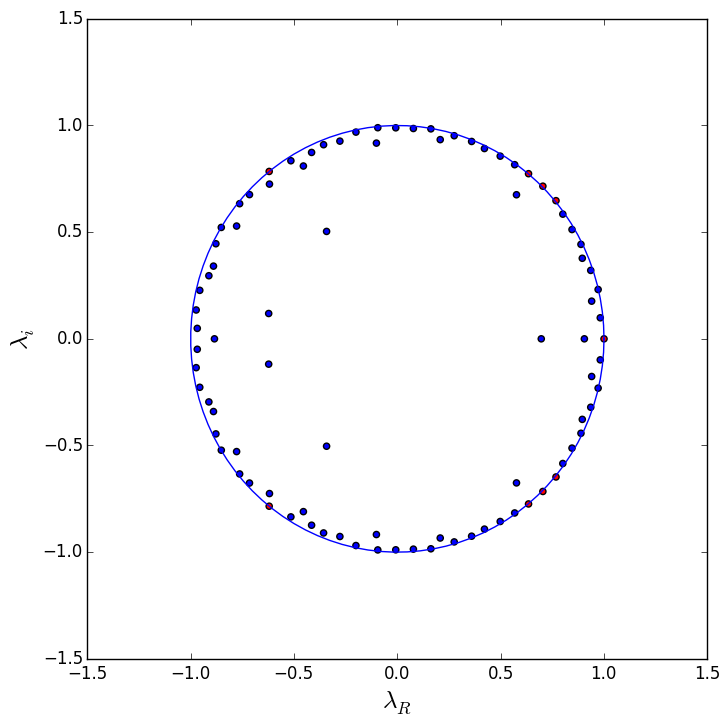

In [31]:
figure(figsize=(8,8))
scatter(real(λ),imag(λ),c=colors)
plot(cos(linspace(0,2*pi)),sin(linspace(0,2*pi)))
ylabel("\$\\lambda_i\$",size=18)
xlabel("\$\\lambda_R\$",size=18)
# ylim([-.4,.4])
savefig("/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-eigenvalues-tu.png")

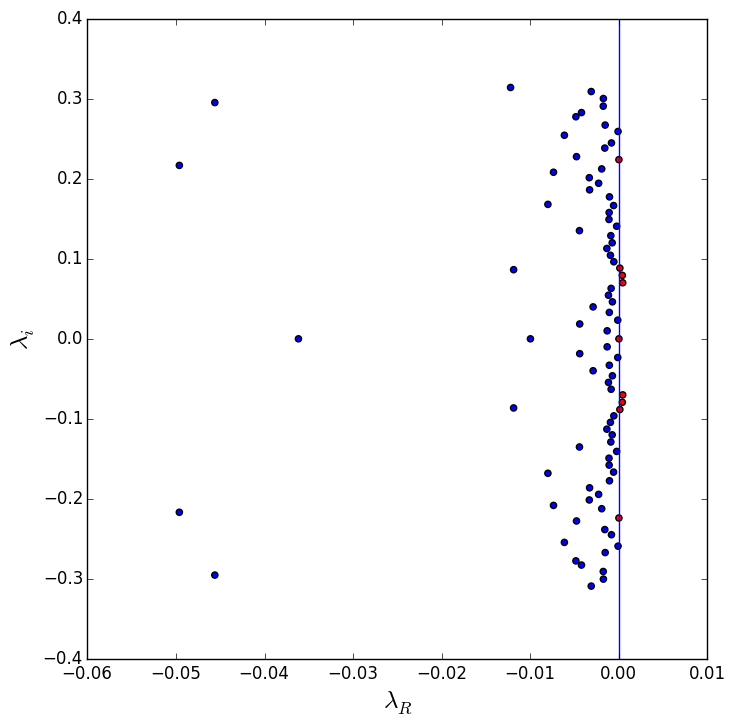

In [32]:
figure(figsize=(8,8))
scatter(real(log(λ)/10),imag(log(λ)/10),c=colors)
plot([0.0,0.0],[-1.0,1.0])
ylabel("\$\\lambda_i\$",size=18)
xlabel("\$\\lambda_R\$",size=18)
ylim([-.4,.4])
savefig("/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-eigenvalues-mapped-tu.png")

### note that the figures look identical to the ones I produced using CTR algorithm

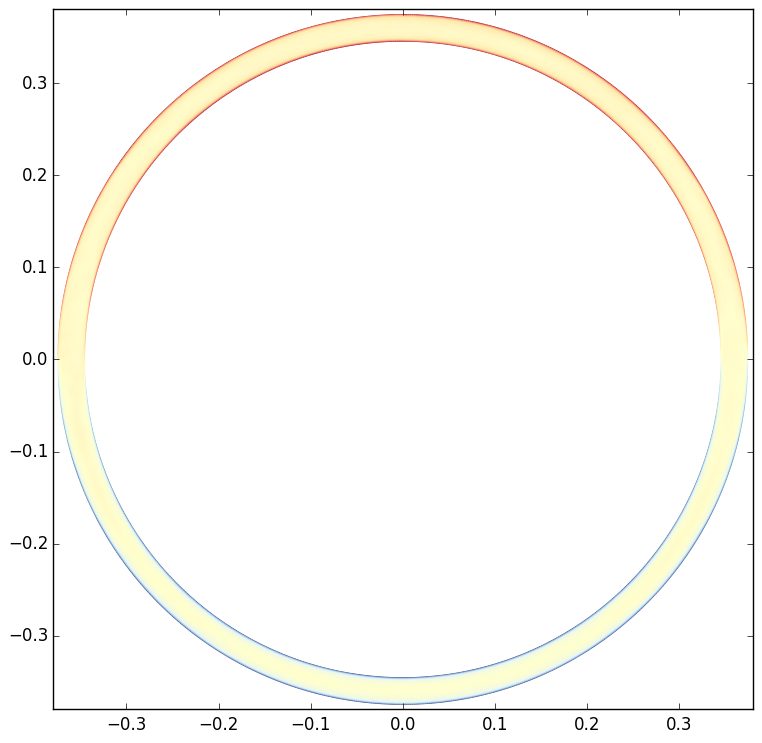

In [34]:
mode = 1
φ = U*w[:,mode]
plot_loop_whole_save((real(φ)-minimum(real(φ)))/(maximum(real(φ))-minimum(real(φ))),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2))-tu.png")

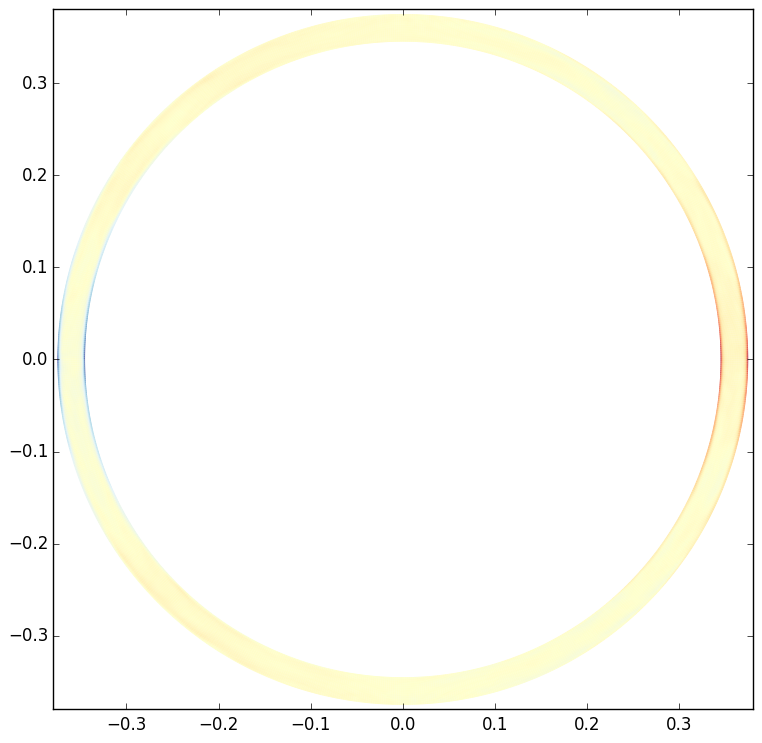

In [35]:
mode = 2
φ = U*w[:,mode]
plot_loop_whole_save((real(φ)-minimum(real(φ)))/(maximum(real(φ))-minimum(real(φ))),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2))-tu.png")

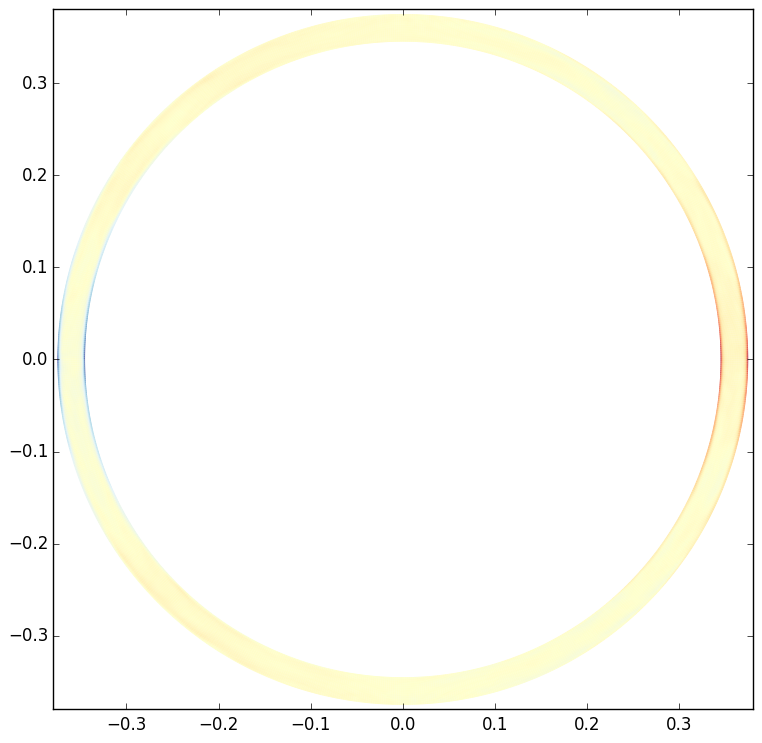

In [36]:
mode = 3
φ = U*w[:,mode]
plot_loop_whole_save((real(φ)-minimum(real(φ)))/(maximum(real(φ))-minimum(real(φ))),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2))-tu.png")

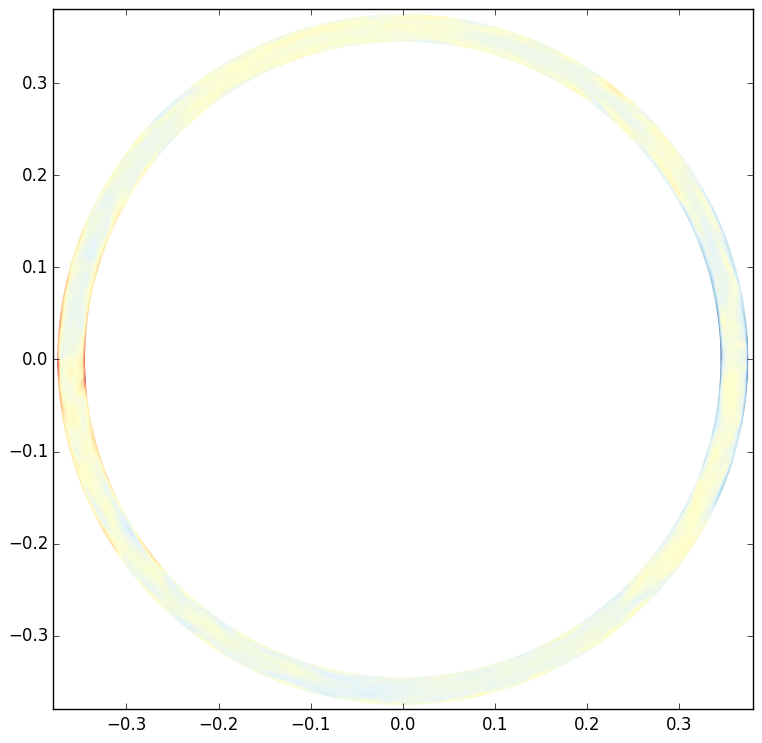

In [37]:
mode = 4
φ = U*w[:,mode]
plot_loop_whole_save((real(φ)-minimum(real(φ)))/(maximum(real(φ))-minimum(real(φ))),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2))-tu.png")

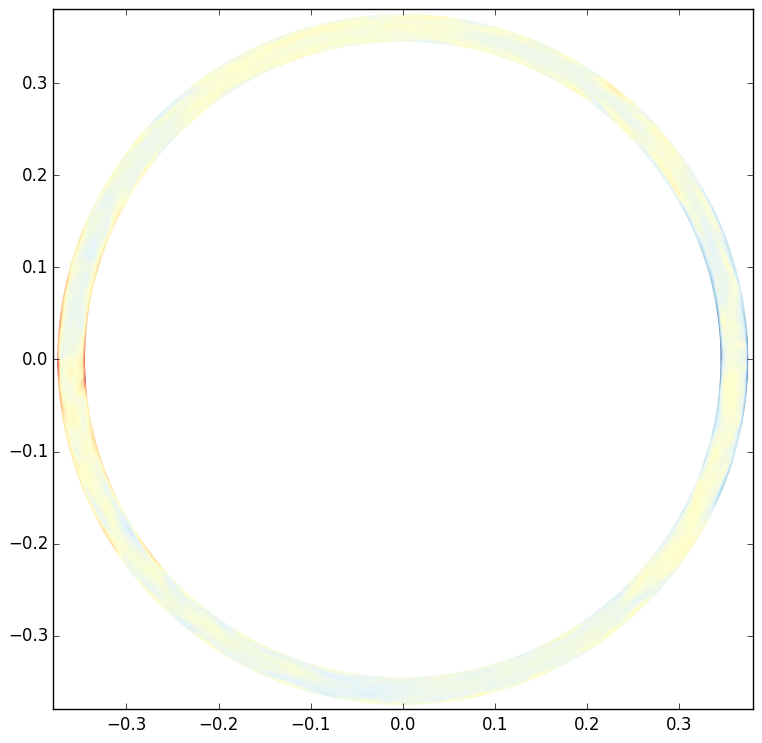

In [38]:
mode = 5
φ = U*w[:,mode]
plot_loop_whole_save((real(φ)-minimum(real(φ)))/(maximum(real(φ))-minimum(real(φ))),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2))-tu.png")

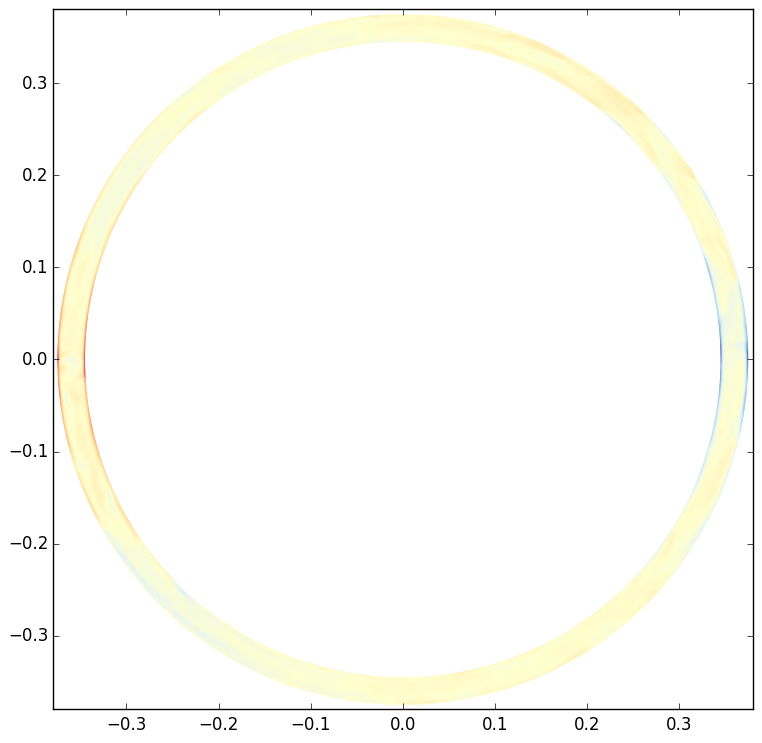

In [39]:
mode = 6
φ = U*w[:,mode]
plot_loop_whole_save((real(φ)-minimum(real(φ)))/(maximum(real(φ))-minimum(real(φ))),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2))-tu.png")

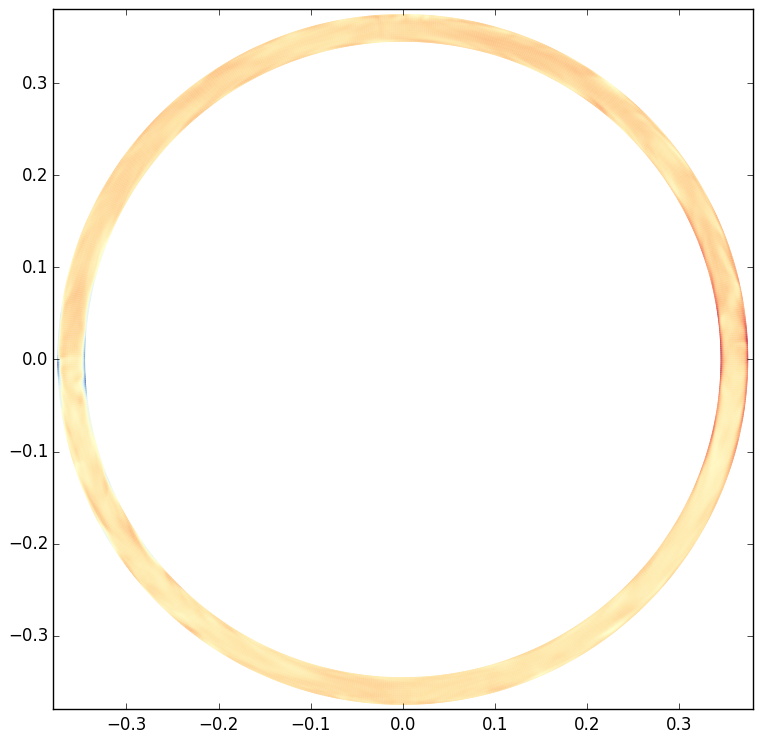

In [40]:
mode = 7
φ = U*w[:,mode]
plot_loop_whole_save((real(φ)-minimum(real(φ)))/(maximum(real(φ))-minimum(real(φ))),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2))-tu.png")

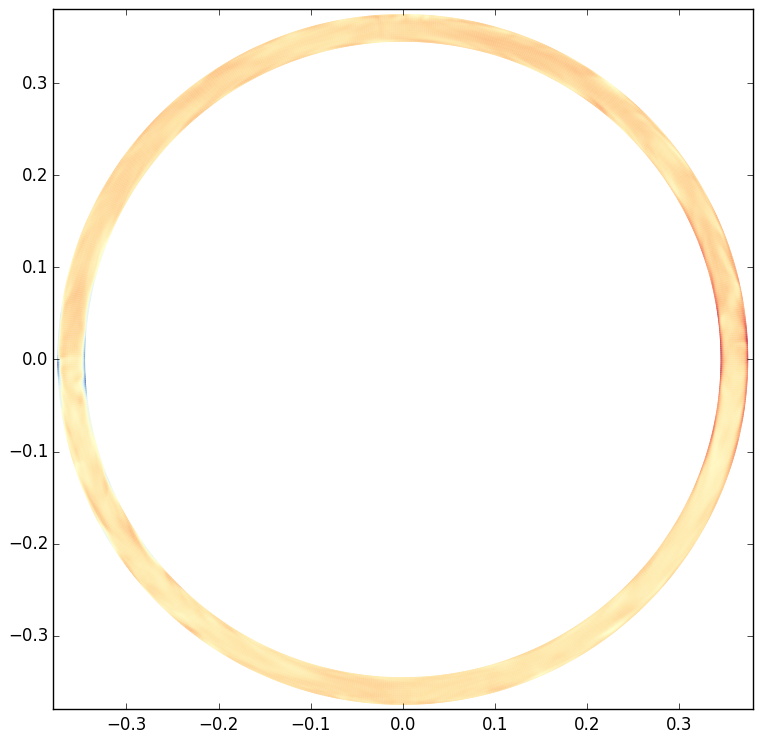

In [41]:
mode = 8
φ = U*w[:,mode]
plot_loop_whole_save((real(φ)-minimum(real(φ)))/(maximum(real(φ))-minimum(real(φ))),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2))-tu.png")

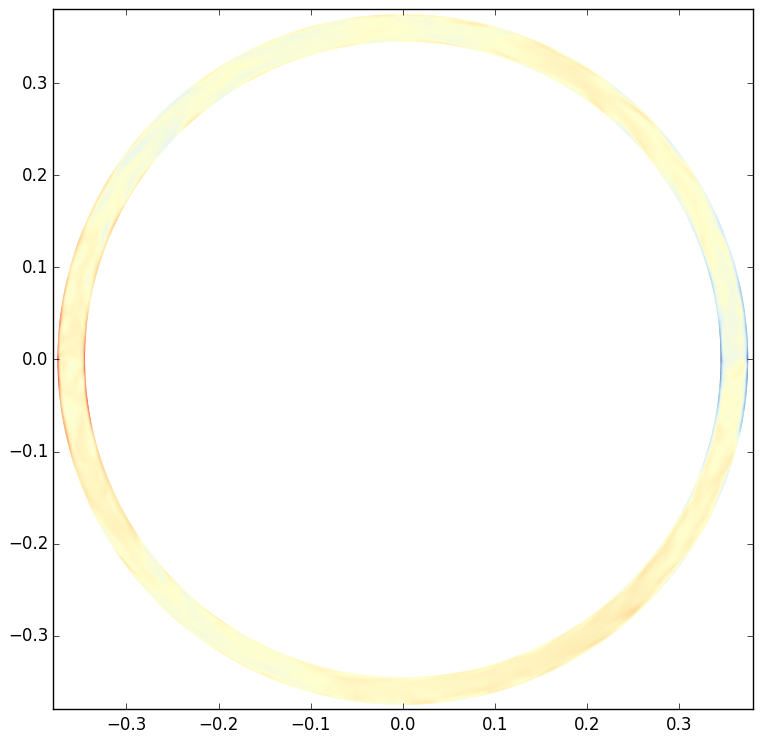

In [42]:
mode = 9
φ = U*w[:,mode]
plot_loop_whole_save((real(φ)-minimum(real(φ)))/(maximum(real(φ))-minimum(real(φ))),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2))-tu.png")

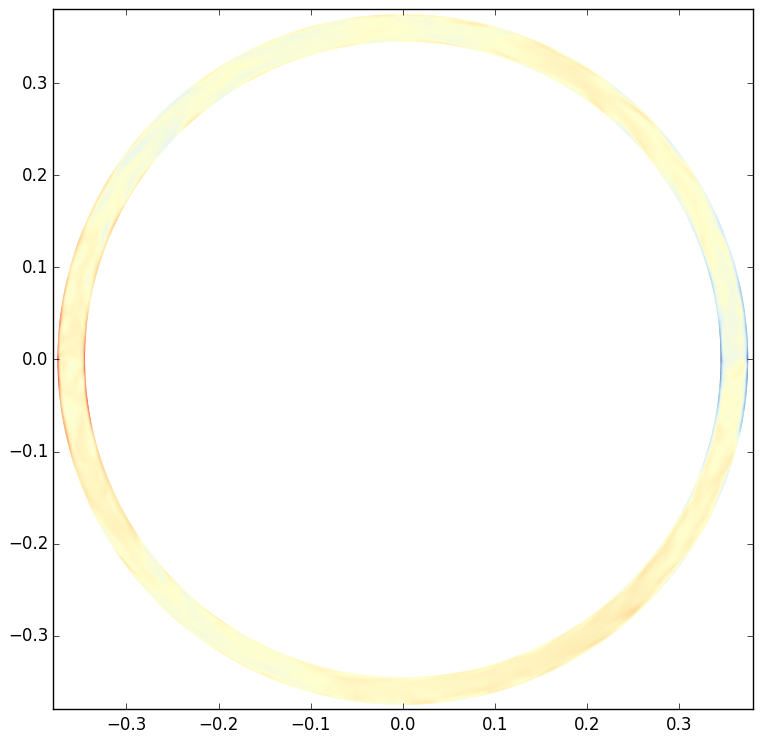

In [43]:
mode = 10
φ = U*w[:,mode]
plot_loop_whole_save((real(φ)-minimum(real(φ)))/(maximum(real(φ))-minimum(real(φ))),"/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode$(dec(mode,2))-tu.png")